In [2]:
%cd /content/drive/MyDrive/research/fine_grained_clf
!ls

/content/drive/MyDrive/research/fine_grained_clf


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gdown https://drive.google.com/u/0/uc?id=10BZN5_BGg21olZA857SMvF0TPgukmVI4&export=download -O .

/bin/bash: -O: command not found
Downloading...
From: https://drive.google.com/u/0/uc?id=10BZN5_BGg21olZA857SMvF0TPgukmVI4
To: /content/drive/MyDrive/research/fine_grained_clf/drink_bottles.zip
100% 498M/498M [00:04<00:00, 107MB/s]


In [ ]:
!unzip drink_bottles.zip -d data

In [ ]:
# unrolling data
"""import shutil
import os

root_path = "./data"
output_dir = "unrolled"
os.makedirs(os.path.join(root_path, output_dir), exist_ok=True)
base_path =  os.path.join(root_path, "images")
for class_folder in os.listdir(base_path):
  print(class_folder)
  img_folder_path = os.path.join(root_path, "images", class_folder)
  for each_img in os.listdir(img_folder_path):
    source = os.path.join(img_folder_path, each_img)
    save_name = f"{class_folder}-" + each_img
    destination = os.path.join(root_path, output_dir, save_name)
    shutil.copy(source, destination)"""

In [7]:
import os
import matplotlib.pyplot as plt

In [8]:
data_dist = {}
for k in os.listdir("data/images"):
  if os.path.isdir(f"data/images/{k}"):
    data_dist[int(k)] = len(os.listdir(f"data/images/{k}"))
data_dist =dict(sorted(data_dist.items()))
data_dist

{1: 1000,
 2: 1000,
 3: 1000,
 4: 1000,
 5: 1000,
 6: 1000,
 7: 163,
 8: 1000,
 9: 1000,
 10: 1000,
 11: 1000,
 12: 1000,
 13: 1000,
 14: 1000,
 15: 1000,
 16: 1000,
 17: 1000,
 18: 1000,
 19: 1000,
 20: 325}

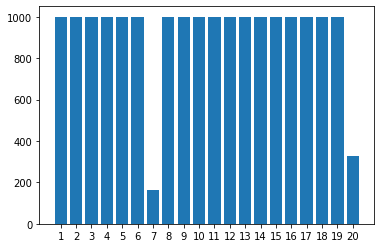

In [9]:
plt.bar(range(len(data_dist)), list(data_dist.values()), align='center')
plt.xticks(range(len(data_dist)), list(data_dist.keys()))
plt.show()

## dataset class

In [10]:
!ls

data  drink_bottles.zip


In [11]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random, os, cv2
from PIL import Image

In [12]:
len(os.listdir("data/unrolled"))

18488

In [13]:
class BottleDataset(Dataset):
  def __init__(self, data_path, split="train"):
    self.split = split
    self.data_path = data_path
    self.split_size = 0.2
    if self.split == "train":
      self.split_size = 1 - self.split_size
    self.transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    # getting all images
    self.img_names = os.listdir(self.data_path)
    # selecting first k of shuffled
    k = int(len(self.img_names)*self.split_size)
    random.shuffle(self.img_names)
    self.data = self.img_names[:k]
    self.visualize()

  def visualize(self):
    data_dist = {}
    for name in self.data:
      k = int(name.split("-")[0])-1
      if k not in data_dist:
        data_dist[k] = 0
      data_dist[k] += 1
    print("\n\n")
    w = 20
    h = 20
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = cv2.imread(os.path.join(self.data_path, self.data[i]))
        fig.add_subplot(rows, columns, i)
        plt.title(int(self.data[i].split("-")[0])-1)
        plt.imshow(img)
    plt.show()
    print("\n\n")
    data_dist =dict(sorted(data_dist.items()))
    plt.bar(range(len(data_dist)), list(data_dist.values()), align='center')
    plt.xticks(range(len(data_dist)), list(data_dist.keys()))
    plt.show()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.data_path, self.data[idx]))
    label = int(self.data[idx].split("-")[0])-1

    if self.transform:
      img = self.transform(img)
      
    return img, label

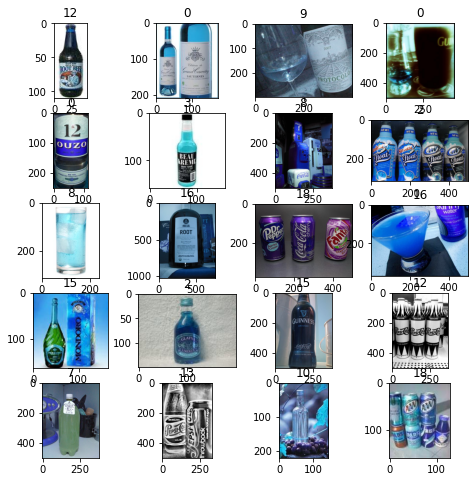

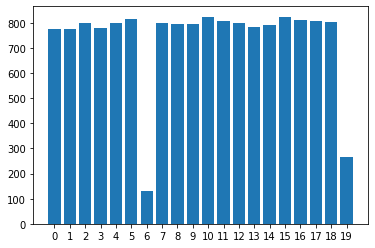

In [14]:
dataset = BottleDataset("data/unrolled")

## dataloader

In [15]:
bottle_dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [16]:
item = next(iter(bottle_dataloader))

## training

In [17]:
import os
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [18]:
class Trainer:
    def __init__(self, model, data_path="./data/unrolled", output_dir="./outputs", epochs=10):
        self.device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        print(summary(self.model, (3,224,224)))
        self.data_path = data_path
        self.train_batch_size = 8
        self.val_batch_size = 4
        self.train_dataloader, self.val_dataloader = self.get_dataloaders()
        self.output_dir = output_dir
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters()) # optim.SGD(self.model.parameters(), lr=1e-1, momentum=0.9) #
        self.criterion = nn.CrossEntropyLoss()
        self.callback_criteria = "val_loss"
        self.global_losses = {"train_loss":1e10, "val_loss" : 1e10}
        self.best_model = None
        

    def get_dataloaders(self):
        # Train Loader
        train_dataset = BottleDataset(self.data_path, split='train')
        train_dataloader = DataLoader(
            dataset=train_dataset, batch_size=self.train_batch_size, shuffle=True)

        # Validation Loader
        val_dataset = BottleDataset(self.data_path, split='val')
        val_dataloader = DataLoader(
            dataset=val_dataset, batch_size=self.val_batch_size, shuffle=True)
        return train_dataloader, val_dataloader


    def loss_func(feat1, feat2):
        return F.cosine_similarity(feat1, feat2).abs()

    
    def custom_callbacks(self, epoch, local_losses):
        save_epoch_path = os.path.join(self.output_dir, f"{epoch}")
        if not os.path.exists(save_epoch_path):
            os.makedirs(save_epoch_path)
        
        self.global_losses = deepcopy(local_losses)
        self.best_model = deepcopy(self.model)

        save_dict = {
            "epoch" : epoch,
            "train_loss" : local_losses['train_loss'],
            "val_loss": local_losses['val_loss'],
            "model": self.best_model.state_dict()
        }
        torch.save(save_dict, save_epoch_path + f"/{epoch}.pth")
        

    def train(self):
      # self.model.train()
      
      running_losses = {"train_loss":0, "val_loss" : 0}
      for epoch in range(self.epochs):
          local_losses = {"train_loss":0, "val_loss" : 0}
          
          # training loop
          loop = tqdm(self.train_dataloader, total = len(self.train_dataloader), leave = True)
          for imgs, labels in loop:
              imgs = imgs.to(self.device)
              labels = labels.to(self.device)
              outputs = self.model(imgs)
              loss = self.criterion(outputs, labels)
              local_losses['train_loss'] += loss.detach().cpu()
              running_losses['train_loss'] += loss.detach().cpu()
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
              loop.set_description(f"Epoch [{epoch}/{self.epochs}]")
              loop.set_postfix({f"train loss": loss.item()})
          
          # validation loop
          with torch.no_grad():
            loop = tqdm(self.val_dataloader, total = len(self.val_dataloader), leave = True)
            for imgs, labels in loop:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                local_losses['val_loss'] += loss.detach().cpu()
                running_losses['val_loss'] += loss.detach().cpu()
                loop.set_description(f"Epoch [{epoch}/{self.epochs}]")
                loop.set_postfix({f"val loss": loss.item()})
          
          if epoch%20==0:
            print(f"Epoch [{epoch}/{self.epochs}] : losses: {running_losses}")
            running_losses = {"train_loss":0, "val_loss" : 0}
            
          if local_losses[self.callback_criteria] < self.global_losses[self.callback_criteria]:
              self.custom_callbacks(epoch=epoch, 
                                    local_losses=local_losses)
              
          print(local_losses)

In [19]:
def get_performance(model, dataloader, device='cuda'):
  label_list = None
  pred_list = None

  loop = tqdm(dataloader, total = len(dataloader), leave = True)
  for imgs, labels in loop:
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)

      if label_list is None:
        label_list = labels.detach().cpu().numpy()
      else:
        label_list = np.concatenate([label_list,
                                      labels.detach().cpu().numpy()])
        
      if pred_list is None:
        pred_list = outputs.detach().cpu().numpy().argmax(axis=1)
      else:
        pred_list = np.concatenate([pred_list,
                                      outputs.detach().cpu().numpy().argmax(axis=1)])
  print("\n\n")
  print(classification_report(label_list, pred_list))

## model

In [20]:
import torch
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F

In [22]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## model 1: Half-frozen pre-trained model

In [23]:
class CustomModel(nn.Module):
    
    def __init__(self, base_model=None, num_classes=20):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.base_model = self.get_custom_model(
            torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True), freeze=True)
        self.act = nn.LeakyReLU()
        self.opt_layer = nn.Linear(1000, self.num_classes)
        
    def is_early_layer(self, name):
        skip_layers = ['conv2d_', 'repeat_1', 'mixed_6', 'repeat_2']
        for sk in skip_layers:
            if sk in name:
                return True
        return False

    def get_custom_model(self, model, freeze=True):
      if not freeze:
        return model
      else:
        for idx, (name, layer) in enumerate(model.named_modules()):
            if isinstance(layer, torch.nn.Conv2d) and idx<34:
                layer.requires_grad_(False)
            else:
                layer.requires_grad_(True)

        

    def sanity_check(self):
      for idx, (name, layer) in enumerate(self.base_model.named_modules()):
            if isinstance(layer, torch.nn.Conv2d):
                print(name, "->",layer.weight.requires_grad)
    
    def forward(self, x):
      ftrs = self.base_model(x)
      act_ftrs = self.act(ftrs)
      logits = self.opt_layer(act_ftrs)
      return logits

In [24]:
custom_model = CustomModel(base_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

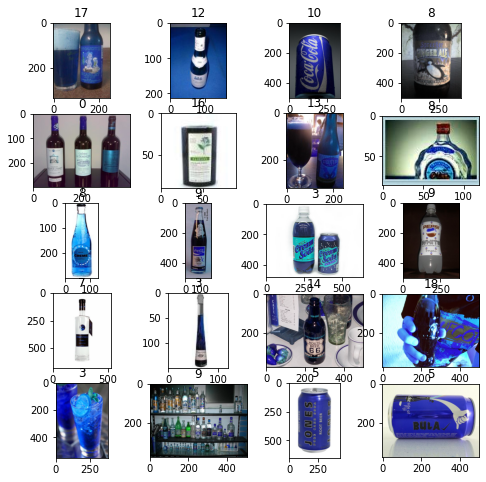

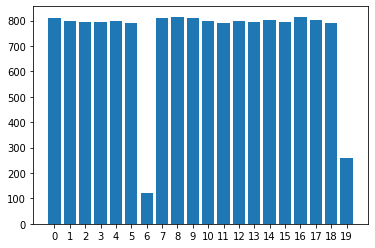

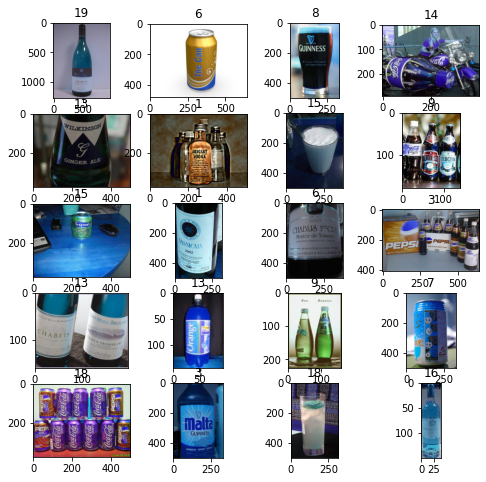

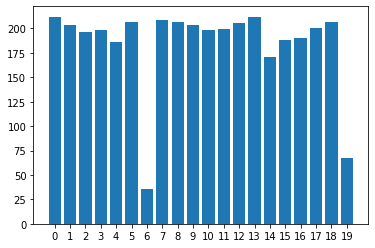

In [25]:
custom_model_train_obj = Trainer(model=custom_model)

In [26]:
custom_model_train_obj.train()

Epoch [0/10]: 100%|██████████| 925/925 [00:51<00:00, 18.13it/s, val loss=2.96]


Epoch [0/10] : losses: {'train_loss': tensor(5509.7759), 'val_loss': tensor(2737.5054)}
{'train_loss': tensor(5509.7759), 'val_loss': tensor(2737.5054)}


Epoch [1/10]: 100%|██████████| 925/925 [00:45<00:00, 20.40it/s, val loss=2.7]


{'train_loss': tensor(5475.0444), 'val_loss': tensor(2738.2546)}


Epoch [2/10]: 100%|██████████| 925/925 [00:45<00:00, 20.48it/s, val loss=2.86]


{'train_loss': tensor(5481.2983), 'val_loss': tensor(2740.0806)}


Epoch [3/10]: 100%|██████████| 925/925 [00:45<00:00, 20.11it/s, val loss=2.63]


{'train_loss': tensor(5471.7617), 'val_loss': tensor(2746.8950)}


Epoch [4/10]: 100%|██████████| 925/925 [00:45<00:00, 20.12it/s, val loss=2.79]


{'train_loss': tensor(5470.1338), 'val_loss': tensor(2741.2783)}


Epoch [5/10]: 100%|██████████| 925/925 [00:45<00:00, 20.44it/s, val loss=2.66]


{'train_loss': tensor(5465.1665), 'val_loss': tensor(2737.1265)}


Epoch [6/10]: 100%|██████████| 925/925 [00:45<00:00, 20.32it/s, val loss=2.83]


{'train_loss': tensor(5467.5757), 'val_loss': tensor(2736.4631)}


Epoch [7/10]: 100%|██████████| 925/925 [00:46<00:00, 19.96it/s, val loss=3]


{'train_loss': tensor(5463.4116), 'val_loss': tensor(2737.1997)}


Epoch [8/10]: 100%|██████████| 925/925 [00:45<00:00, 20.18it/s, val loss=3.19]


{'train_loss': tensor(5464.1372), 'val_loss': tensor(2733.7356)}


Epoch [9/10]: 100%|██████████| 925/925 [00:47<00:00, 19.65it/s, val loss=2.95]

{'train_loss': tensor(5462.0674), 'val_loss': tensor(2736.4116)}


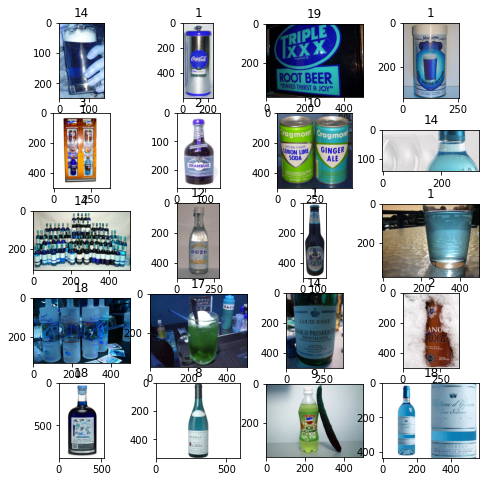

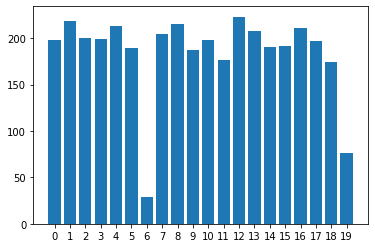

In [27]:
val_dataset = BottleDataset("./data/unrolled", split='val')
val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=16, shuffle=True)

In [28]:
# testing performance
get_performance(custom_model_train_obj.model, val_dataloader)

100%|██████████| 232/232 [00:40<00:00,  5.75it/s]




              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.00      0.00      0.00       218
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00       199
           4       0.00      0.00      0.00       213
           5       0.00      0.00      0.00       189
           6       0.00      0.00      0.00        29
           7       0.06      0.64      0.10       204
           8       0.00      0.00      0.00       215
           9       0.00      0.00      0.00       187
          10       0.00      0.00      0.00       198
          11       0.00      0.00      0.00       176
          12       0.00      0.00      0.00       223
          13       0.05      0.06      0.05       208
          14       0.00      0.00      0.00       190
          15       0.00      0.00      0.00       192
          16       0.06      0.27      0.09       211
          17       0.00 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## model 2: simple conv

In [33]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
cstm_classifier = CustomClassifier()
summary(cstm_classifier.to('cuda'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 20]           1,700
Total params: 5,408,136
Trainable params: 5,408,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.63
Estimated Total Size (MB): 25.69
----------------------------------------------------------------


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 20]           1,700
Total params: 5,408,136
Trainable params: 5,408,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.63
Estimated Total Size (MB): 25.69
----------------------------------------------------------------
None





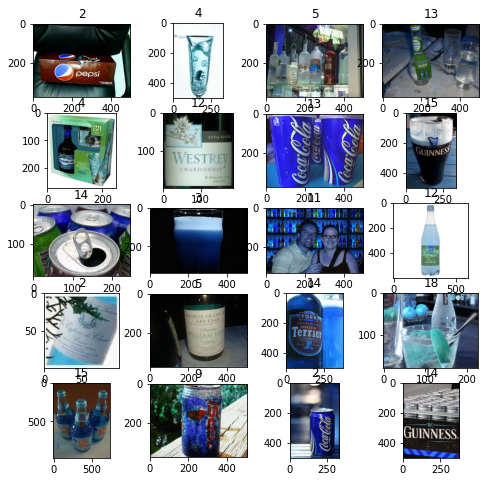

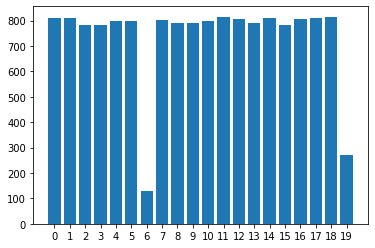

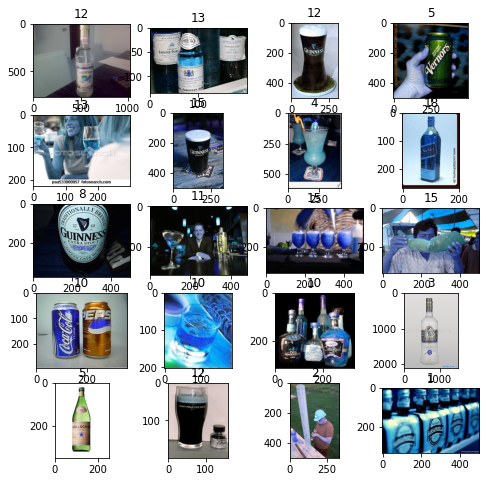

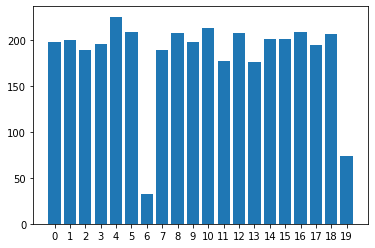

In [35]:
cstm_classifier_train_obj = Trainer(model=cstm_classifier)

In [36]:
cstm_classifier_train_obj.train()

Epoch [0/10]: 100%|██████████| 925/925 [00:34<00:00, 27.00it/s, val loss=2.95]


Epoch [0/10] : losses: {'train_loss': tensor(5477.2842), 'val_loss': tensor(2735.7573)}
{'train_loss': tensor(5477.2842), 'val_loss': tensor(2735.7573)}


Epoch [1/10]: 100%|██████████| 925/925 [00:34<00:00, 26.62it/s, val loss=2.85]


{'train_loss': tensor(5466.8374), 'val_loss': tensor(2733.3167)}


Epoch [2/10]: 100%|██████████| 925/925 [00:33<00:00, 27.46it/s, val loss=2.79]


{'train_loss': tensor(5463.8589), 'val_loss': tensor(2715.5959)}


Epoch [3/10]: 100%|██████████| 925/925 [00:34<00:00, 26.92it/s, val loss=3.05]


{'train_loss': tensor(5139.2402), 'val_loss': tensor(2124.9590)}


Epoch [4/10]: 100%|██████████| 925/925 [00:33<00:00, 27.45it/s, val loss=0.863]


{'train_loss': tensor(2910.3813), 'val_loss': tensor(1334.5396)}


Epoch [5/10]: 100%|██████████| 925/925 [00:33<00:00, 27.74it/s, val loss=0.192]


{'train_loss': tensor(1021.9899), 'val_loss': tensor(1499.2256)}


Epoch [6/10]: 100%|██████████| 925/925 [00:33<00:00, 27.85it/s, val loss=0.000308]


{'train_loss': tensor(511.5367), 'val_loss': tensor(1689.3766)}


Epoch [7/10]: 100%|██████████| 925/925 [00:33<00:00, 27.78it/s, val loss=9.89e-6]


{'train_loss': tensor(342.9896), 'val_loss': tensor(1545.2849)}


Epoch [8/10]: 100%|██████████| 925/925 [00:33<00:00, 27.31it/s, val loss=0.000187]


{'train_loss': tensor(277.5028), 'val_loss': tensor(1814.0793)}


Epoch [9/10]: 100%|██████████| 925/925 [00:33<00:00, 27.71it/s, val loss=0.00411]

{'train_loss': tensor(237.3553), 'val_loss': tensor(1826.0691)}


In [37]:
# testing performance
get_performance(cstm_classifier_train_obj.model, val_dataloader)

100%|██████████| 232/232 [00:25<00:00,  8.93it/s]





              precision    recall  f1-score   support

           0       0.81      0.83      0.82       198
           1       0.84      0.84      0.84       218
           2       0.82      0.82      0.82       200
           3       0.75      0.78      0.76       199
           4       0.65      0.80      0.71       213
           5       0.82      0.85      0.84       189
           6       0.96      0.90      0.93        29
           7       0.75      0.81      0.78       204
           8       0.88      0.76      0.81       215
           9       0.84      0.76      0.80       187
          10       0.77      0.79      0.78       198
          11       0.85      0.81      0.83       176
          12       0.92      0.80      0.86       223
          13       0.78      0.80      0.79       208
          14       0.87      0.75      0.81       190
          15       0.84      0.82      0.83       192
          16       0.82      0.81      0.81       211
          17       0.79 

## model 3: Custom model: better arch



In [38]:
class Encoder_block(nn.Module):
  def __init__(self, input_kernel_nums, output_kernel_nums, kernel_size):
    super(Encoder_block, self).__init__()
    self.conv = nn.Conv2d(input_kernel_nums, output_kernel_nums, kernel_size)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn = nn.BatchNorm2d(100)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    x = self.bn(x)
    return x

class TaskModel(nn.Module):
  def __init__(self, input_size, num_classes):
    super(TaskModel, self).__init__()
    self.cnn_block1 = Encoder_block(3, 8, 7)
    self.cnn_block2 = Encoder_block(8, 16, 5)
    self.cnn_block3 = Encoder_block(16, 32, 5)
    self.cnn_block4 = Encoder_block(32, 64, 3)
    self.drop3 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.3)
    self.drop1 = nn.Dropout(0.4)
  
  def forward(self, x):
    x = self.cnn_block1(x)
    x = self.drop1(x)
    x = self.cnn_block2(x)
    x = self.drop2(x)
    x = self.cnn_block3(x)
    x = self.drop3(x)
    x = self.cnn_block4(x)
    print(x.shape)
    return x

In [ ]:
task_classifier = TaskModel()
summary(task_classifier.to('cuda'), (3,224,224))

In [ ]:
task_classifier = Trainer(model=cstm_classifier)

In [ ]:
task_classifier.train()

In [ ]:
# testing performance
get_performance(task_classifier.model, val_dataloader)